In [ ]:
import h5py
import numpy as np
from tqdm import tqdm
import time

def crop_image(image: np.ndarray, pix: int = 2) -> np.ndarray:
    return image[pix:-pix, pix:-pix, :]

def normalize_image(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    min_vals = image.min(axis=(0, 1), keepdims=True)
    max_vals = image.max(axis=(0, 1), keepdims=True)
    range_vals = np.maximum(max_vals - min_vals, 1e-5)
    return (image - min_vals) / range_vals

h5_path = 'D:/BBBC021/BBBC021_dataset.h5'

# Function to load the HDF5 file and benchmark the preprocessing
with h5py.File(h5_path, 'r') as h5f:
    images = h5f['images']
    N = len(images)

    print(f"\nBenchmarking {N} images with preprocessing...")
    start = time.time()
    skipped = 0
    for i in tqdm(range(N)):
        img = crop_image(images[i])
        if img is None:
            skipped += 1
            continue
        img = normalize_image(img)
        img = np.transpose(img, (2, 0, 1))
    preprocess_time = time.time() - start
    print(f"Preprocessing time: {preprocess_time:.2f} seconds ({N - skipped} images)")

    print(f"\nBenchmarking {N} images with no preprocessing...")
    start = time.time()
    for i in tqdm(range(N)):
        _ = images[i]
    no_preprocess_time = time.time() - start
    print(f"Raw load time: {no_preprocess_time:.2f} seconds ({N} images)")

    print(f"\nTime difference: {preprocess_time - no_preprocess_time:.2f} seconds")
    print(f"Per-image overhead: {(preprocess_time - no_preprocess_time) / (N - skipped):.6f} seconds")


In [ ]:
import h5py
import numpy as np
from tqdm import tqdm
import os

# Define your noisy long IDs
noisy_ids = {
    "C11_s1_w127B03F50-0445-404D-8686-992152316A15",
    "G02_s2_w17DA4AF6A-01FB-4517-9E5B-CCDD62A1D4B6",
    "Week1_150607_B03_s2_w16BAE18E6-E27B-4683-90FA-581B8ADA6CB1", # maybe
    "Week1_150607_E04_s4_w12BDBC4CA-CCA1-48C8-B4D5-F229EB266410", # maybe
    "Week1_150607_E11_s1_w1F5053E7F-88CD-40F8-AAE0-0633FF5CBBA4", # maybe
    "Week1_150607_E11_s2_w185FD4BFE-407C-43FA-8376-281D21993540", # maybe
    "Week2_180607_E02_s3_w109D7263C-9A3C-4717-B6AA-BA1ECCF45A70", # maybe
    "Week2_180607_F02_s4_w14EBE2925-CBA5-42C4-8853-A78BACC04D3C",
    "Week3_290607_B11_s3_w1E2E13398-A442-40FE-AF91-FB9B55A9D664",
    "Week5_130707_C11_s4_w1EBDD4E60-9887-4A72-BFD1-C3D6EB633BE4",
    "Week5_130707_C11_s4_w116C137AD-BD10-4685-984A-A8E52DA612BA",
    "Week5_130707_D02_s2_w1286A02BA-8BE0-4267-B919-E6223AB4F182",
    "Week6_200607_C11_s3_w19357A9CA-9915-45A9-8F2E-09B6AE811524",
    "Week6_200607_E02_s2_w13ED36977-F80B-40C5-8151-7CF6DB9782AE",
    "Week6_200607_E11_s4_w1AABB4630-0530-43D7-B915-902AA6480CC3",
    "Week7_230707_C06_s2_w1D292D8D5-F5A6-4CC9-9A28-D4713C8D8076",
    "Week7_230707_E02_s2_w182895F08-11E3-4AB6-B2B8-1BEECE2862F4",
    "Week7_230707_F02_s1_w176094EF3-CBD9-4F0C-8388-D0A55B172980",
    "Week7_230707_G02_s2_w1B5CBE42C-5E9F-4F2C-8094-23EF0BF691AA",
    "Week7_230707_G02_s3_w1D044621A-12B7-4CCC-AD48-B4EFC5C0D221",
    "Week8_4sites_B02_s2_w14F7C0A4C-02B2-49C5-909F-37CB44AD0FDF", # maybe
    "Week8_4sites_C09_s2_w14A741543-3F34-49DE-A541-EB80EA9D937D",
    "Week8_4sites_E11_s3_w13E4113DB-0EB6-4ED5-BB6E-1E3EE3F5EE57",
    "Week9_090907_C02_s2_w1A5369617-A74F-4F39-BF1F-D5834D20B5C0",
    "Week9_090907_C11_s3_w195438B0C-C73B-471B-AF96-85FA31D58F37", # maybe
}

input_path = 'D:/BBBC021/BBBC021_dataset.h5'
output_path = 'D:/BBBC021/BBBC021_dataset_cleaned_maxnorm_68.h5'

# Preprocessing functions
def crop_image(image: np.ndarray, pix: int = 2) -> np.ndarray:
    return image[pix:-pix, pix:-pix, :] if image.shape == (68, 68, 3) else None

def max_normalize_image(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    max_vals = image.max(axis=(0, 1), keepdims=True)  # shape (1, 1, C)
    max_vals = np.maximum(max_vals, 1e-5)  # prevent division by 0
    return image / max_vals

def is_noisy(name: str, bad_ids: set) -> bool:
    prefix = '_'.join(name.split('_')[:-1])  # Remove the last `_###` part
    return prefix in bad_ids

# Processing
with h5py.File(input_path, 'r') as in_f, h5py.File(output_path, 'w') as out_f:
    raw_images = in_f['images']
    raw_names = in_f['image_names']
    total = len(raw_images)

    img_shape = (3, 68, 68)
    img_dtype = np.float32

    # Create resizable datasets in output file
    image_dataset = out_f.create_dataset(
        'images',
        shape=(0, *img_shape),
        maxshape=(None, *img_shape),
        dtype=img_dtype,
        chunks=(1, *img_shape),
        compression='gzip'
    )

    name_dataset = out_f.create_dataset(
        'image_names',
        shape=(0,),
        maxshape=(None,),
        dtype=h5py.string_dtype(),
        compression='gzip'
    )

    index = 0
    for i in tqdm(range(total), desc="Processing Images"):
        name = raw_names[i].decode('utf-8')
        if is_noisy(name, noisy_ids):
            print(f"Removed image: {name}")
            continue

        img = raw_images[i]
        # img = crop_image(img)
        # if img is None:
        #     continue

        img = max_normalize_image(img)
        img = np.transpose(img, (2, 0, 1))

        # Save to output dataset
        image_dataset.resize(index + 1, axis=0)
        name_dataset.resize(index + 1, axis=0)

        image_dataset[index] = img
        name_dataset[index] = name.encode('utf-8')
        index += 1

print(f"\nSaved {index} cleaned & preprocessed images to: {output_path}")

In [3]:
import h5py

# Path to the cleaned + preprocessed dataset
h5_path = 'D:/BBBC021/BBBC021_dataset_cleaned_maxnorm_68.h5'

with h5py.File(h5_path, 'r') as h5f:
    images = h5f['images']
    names = h5f['image_names']

    num_images = images.shape[0]
    img_shape = images.shape[1:]
    dtype = images.dtype

    print(f"Dataset loaded from: {h5_path}")
    print(f"Number of images: {num_images}")
    print(f"Image shape: {img_shape}")
    print(f"Data type: {dtype}")
    print(f"Sample names: {[names[i].decode('utf-8') for i in range(min(5, num_images))]}")

Dataset loaded from: D:/BBBC021/BBBC021_dataset_cleaned_maxnorm_68.h5
Number of images: 480763
Image shape: (3, 68, 68)
Data type: float32
Sample names: ['B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_0.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_1.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_10.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_100.npy', 'B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10_101.npy']


In [12]:
# Sample 1000 images and plot the distribution of pixel values in the 3 channels in 3 subplots of histograms
import matplotlib.pyplot as plt
import random
def plot_pixel_value_distribution(images: np.ndarray, num_samples: int = 1000):
    indices = random.sample(range(images.shape[0]), num_samples)
    sampled_images = images[indices]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['red', 'green', 'blue']
    channel_names = ['Channel 1', 'Channel 2', 'Channel 3']

    for i in range(3):
        axs[i].hist(sampled_images[:, i, :, :].ravel(), bins=50, color=colors[i], alpha=0.7)
        axs[i].set_title(f'Pixel Value Distribution - {channel_names[i]}')
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

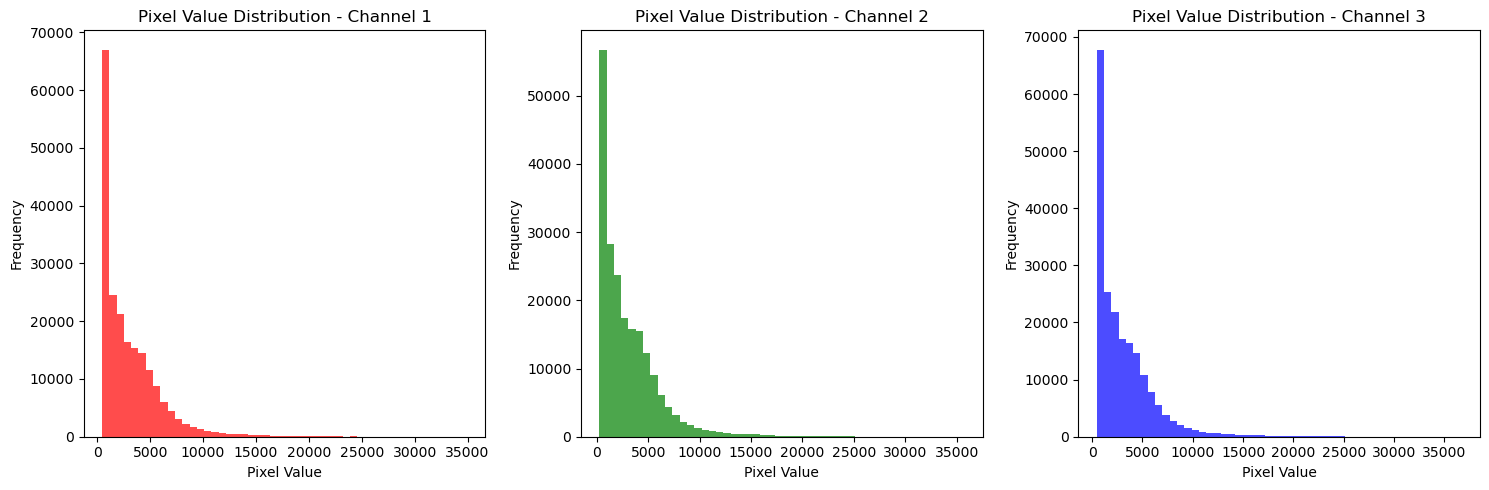

In [24]:
h5_path1 = 'D:/BBBC021/BBBC021_dataset.h5'
with h5py.File(h5_path1, 'r') as h5f:
    images = h5f['images']
    plot_pixel_value_distribution(images[:100000])  # Plot distribution for the first 1000 images

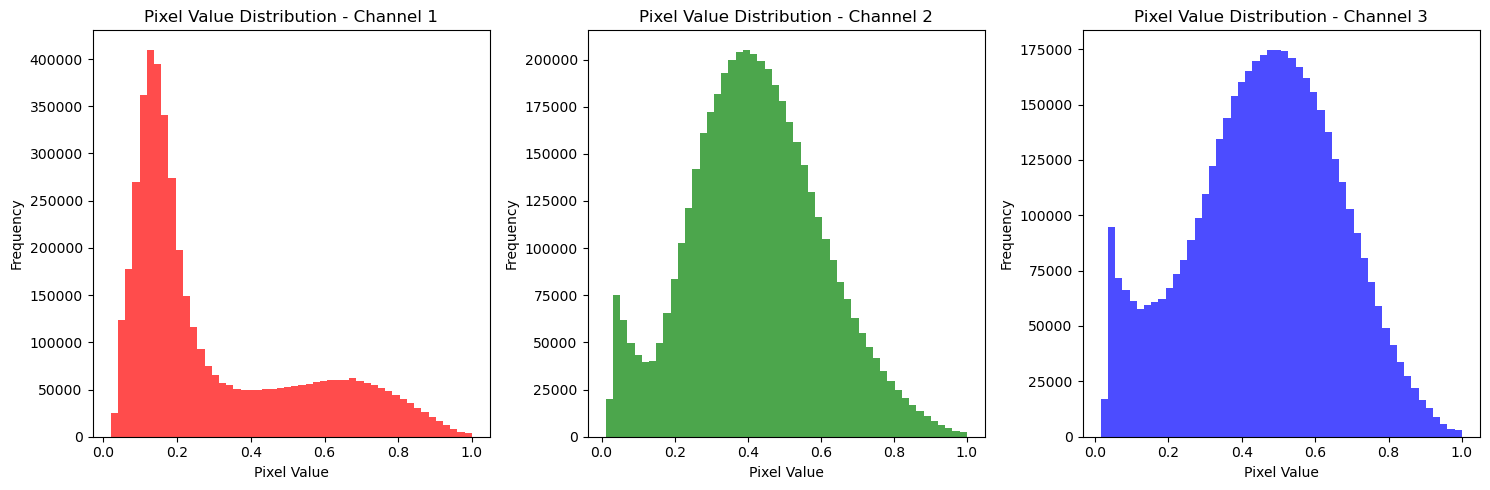

In [23]:
# Max-normalized cleaned dataset
h5_path2 = 'D:/BBBC021/BBBC021_dataset_cleaned_maxnorm_68.h5'
with h5py.File(h5_path2, 'r') as h5f:
    images = h5f['images']
    plot_pixel_value_distribution(images[:100000])  # Plot for the first 1000 images

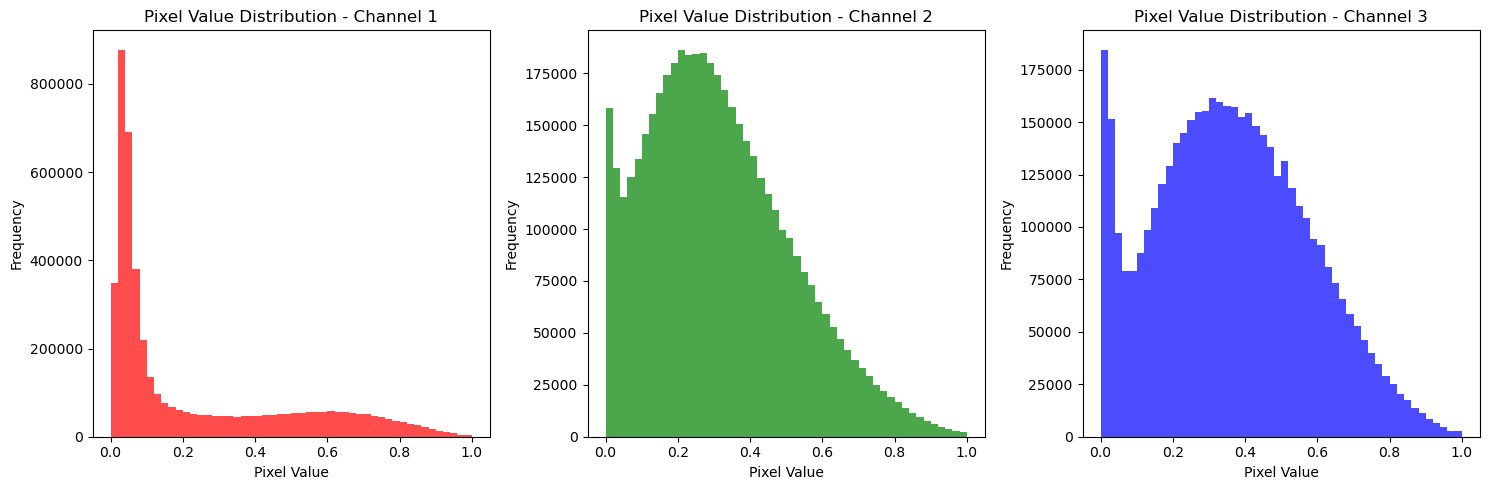

In [25]:
# Min max normalization of the cleaned dataset
h5_path3 = 'D:/BBBC021/BBBC021_cleaned_preprocessed_68.h5'
with h5py.File(h5_path3, 'r') as h5f:
    images = h5f['images']
    plot_pixel_value_distribution(images[:100000])  # Plot for the first 1000 images